<a href="https://colab.research.google.com/github/PashaIanko/Kaggle.Restaurant-Revenue-Prediction/blob/main/model_preparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- Stretch tasks:
    - CV
    - best_params_
    - Short list of models
    - sklearn.metrics module

# Imports

In [151]:
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Models
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR

# Grid search
from sklearn.model_selection import GridSearchCV

# Metrics
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

# Setup paths

In [ ]:
drive.mount('/content/gdrive')
gdrive_path = '/content/gdrive/MyDrive/'
df_path = 'ML/Datasets/5.RestaurantRevenue/'

train_path = gdrive_path + df_path + "train.csv"
train_processed_path = gdrive_path + df_path + "trainval_processed.csv"
test_processed_path = gdrive_path + df_path + "test_processed.csv"
test_path =  gdrive_path + df_path + "test.csv"
submission_path = gdrive_path + df_path + "submission.csv"
sample_submission_path = gdrive_path + df_path + "sampleSubmission.csv"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Download the data

In [ ]:
df_test = pd.read_csv(test_processed_path, index_col=[0])
df_test.head(2)

,0,1,2,3,4,5,6,7,8,9,...,34,35,36,37,38,39,40,41,42,43
0,-1.032819,-1.653875,0.688913,-1.382555,-0.807152,-0.633614,-2.019553,-0.062452,-0.217343,-0.244523,...,-0.606797,-0.556056,-0.652386,2008.0,0.0,0.0,1.0,0.0,1.134031,14.842280
1,0.015056,0.397991,-0.268140,-1.382555,-0.807152,-0.159426,-0.182156,-0.062452,-0.217343,-0.244523,...,0.655776,0.253599,0.511872,2007.0,0.0,0.0,0.0,1.0,1.769000,15.312391


In [ ]:
df_trainval = pd.read_csv(train_processed_path, index_col=[0])
df_trainval.head(2)

,0,1,2,3,4,5,6,7,8,9,...,34,35,36,37,38,39,40,41,42,43
0,-0.334236,-0.285964,-1.225193,-0.383325,0.014161,-0.633614,-0.182156,-0.062452,-0.217343,-0.244523,...,0.655776,0.253599,1.094000,2009.0,0.0,0.0,0.0,1.0,2.069,15.278005
1,-0.683527,-0.285964,-1.225193,0.615905,1.656785,0.788952,-0.182156,-0.619713,-0.790338,-0.811816,...,-0.606797,-0.556056,-0.652386,2007.0,1.0,0.0,1.0,0.0,5.663,15.255171


In [ ]:
X_train_val = df_trainval.values[:, :-1]
Y_train_val = df_trainval.values[:, -1]

In [ ]:
X_test = df_test.values[:, :-1]
Y_test = df_test.values[:, -1]

# Select and train models (+ ensemble methods)

## Preliminary look (shortlisting 2-5 models)

In [ ]:
def plot_model_scores(models_dict_, X_, Y_, cv_, scoring_):
    res = {}
    for name, model in models_dict_.items():
        scores = cross_val_score(
            model,
            X_,
            Y_,
            cv=cv_,
            scoring=scoring_
        )
        res[name] = scores
    
    # Sort the dict
    sorted_res = {
        k:v for \
        k, v in sorted(res.items(), key = lambda item: np.mean(item[1]))
    }
    for model_name, scores in sorted_res.items():
        print(f'Model: {model_name}, mean: {np.mean(scores)}, std: {np.std(scores)}')

    return sorted_res

In [ ]:
_ = plot_model_scores(
    {
        'RF': RandomForestRegressor(),
        'LinReg': LinearRegression(),
        'Tree': DecisionTreeRegressor(),
        'Lasso': Lasso(),
        'SVM': SVR(),
        'Elastic': ElasticNet()
    },
    X_=X_train_val,
    Y_=Y_train_val,
    cv_=7,
    scoring_='neg_mean_squared_error'
)

Model: LinReg, mean: -0.3002927795320557, std: 0.0841214493207769
Model: Tree, mean: -0.2939816454239583, std: 0.07160641010456664
Model: SVM, mean: -0.23975755066794463, std: 0.10254520924351965
Model: Lasso, mean: -0.2331971333481854, std: 0.101789341582441
Model: Elastic, mean: -0.21569093211351922, std: 0.10074172443016455
Model: RF, mean: -0.19458775007617748, std: 0.06551366374469633


In [ ]:
from dataclasses import dataclass, field

@dataclass
class Model:
    model: None
    name: str
    grid_search_param_grid: list 
    random_search_param_grid: list

In [ ]:
RFModel = Model(
    RandomForestRegressor(),
    'RF',
    [
        {'n_estimators': [100, 200, 500]}
    ],

    [
        {
            'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800],
            'max_depth': [i for i in range(1, 20)]
        }
    ]
)

ElasticNetModel = Model(
    ElasticNet(),
    'Elastic',
    [
        {
            'alpha': [0.1, 0.3, 0.5],
            'l1_ratio': [0.2, 0.4]
        }, 
    ],
    [
        {}
    ]
)

In [ ]:
shortlisted_models = {
    model.name: model for model in [RFModel, ElasticNetModel]
}

# Fine tuning

## Grid search

In [ ]:
def fit_grid_search(models_dict_, X_, Y_, cv_, scoring_):
    res = {
        name: None for name in list(models_dict_.keys())
    }

    for name, model in models_dict_.items():
        print(f'Fitting {name}')
        
        grid_search_estimator = GridSearchCV(
            model.model,
            param_grid=model.grid_search_param_grid,
            cv=cv_,
            scoring=scoring_,
            return_train_score=True,
            refit=True
        )

        grid_search_result = grid_search_estimator.fit(X_, Y_)
        res[name] = grid_search_result
    return res

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

def fit_randomized_search(models_dict_, X_, Y_, cv_, n_iter_, scoring_):
    res = {}
    for name, model in models_dict_.items():
        print(f'Fitting {name}')

        estimator = RandomizedSearchCV(
            model.model,
            param_distributions = model.random_search_param_grid,
            cv=cv_,
            n_iter=n_iter_,
            scoring = scoring_,
            return_train_score=True,
            refit=True
        )

        rand_search_res = estimator.fit(X_, Y_)
        res[name] = rand_search_res
    return res

In [ ]:
grid_search_results = fit_grid_search(
    shortlisted_models,
    X_=X_train_val,
    Y_=Y_train_val,
    cv_ = 5,
    scoring_ = 'neg_mean_squared_error'
)

Fitting RF
Fitting Elastic


In [ ]:
print(grid_search_results['RF'].best_params_)
print(grid_search_results['Elastic'].best_estimator_)

{'n_estimators': 200}
ElasticNet(alpha=0.5, l1_ratio=0.2)


## Randomized search

In [ ]:
rand_search_results = fit_randomized_search(
    shortlisted_models,
    X_=X_train_val,
    Y_=Y_train_val,
    cv_=5,
    n_iter_=5,
    scoring_='neg_mean_squared_error'
)

Fitting RF
Fitting Elastic


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:296: UserWarning: The total space of parameters 1 is smaller than n_iter=5. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,


In [ ]:
rand_search_results['RF'].best_estimator_

RandomForestRegressor(max_depth=19, n_estimators=700)

# Model mistake analysis

In [ ]:
grid_search_results['RF'].best_estimator_.feature_importances_, np.arange()

(array([3.14047158e-02, 2.80601170e-02, 1.99154648e-02, 1.34363135e-02,
        2.08759971e-02, 2.26369775e-02, 3.08943629e-03, 1.50156608e-02,
        6.88828246e-03, 8.90961636e-03, 2.46223152e-02, 2.20707717e-02,
        9.48403896e-03, 4.07478127e-03, 2.81845397e-03, 4.42509979e-03,
        1.58865656e-02, 5.71963595e-03, 3.50945553e-02, 3.28145412e-02,
        3.69896855e-02, 2.90400706e-02, 1.50521549e-02, 4.75724448e-03,
        1.62745501e-02, 6.41991127e-03, 9.74460389e-03, 7.82135395e-02,
        6.71249287e-02, 1.16843947e-02, 4.51679938e-03, 6.11453739e-03,
        4.54834043e-03, 4.40224468e-03, 3.39735540e-03, 3.40768619e-03,
        5.65053560e-03, 2.24247487e-01, 2.00753420e-03, 2.25559456e-06,
        3.12646271e-03, 3.34713302e-03, 1.32687204e-01]),)

<BarContainer object of 43 artists>

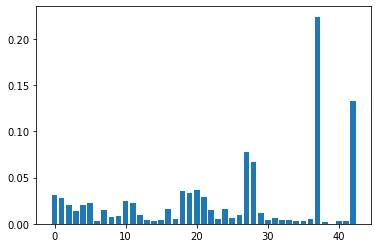

In [ ]:
plt.bar(
    np.arange(len(grid_search_results['RF'].best_estimator_.feature_importances_)),
    grid_search_results['RF'].best_estimator_.feature_importances_
)

# Saving best models (pickle)